#### Adam Klie<br>05/06/2020
# Process downloaded data into necessary Qiime2 artifacts
Create core qiime2 artifacts for 16S microbiome analysis
 - __Input__: 
     - ..data/.../samples.biom table : BIOMV210Format
     - ../data/.../metadata.tsv : tab seperated table
 - __Output__
     - _Artifacts_
         - insertion-table.qza : FeatureTable[Frequency]
         - rep-seqs.qza : FeatureData[Sequence]
         - sepp-tree.qza : Phylogeny[Rooted]
         - bespoke-taxonomy.qza : FeatureData[Taxonomy]
     - _Visualizations_
         - insertion-table.qzv
         - rep-seqs.qzv
         - sepp-tree.qzv
         - bespoke-taxonomy.qzv

## Requirements
 - Follow README.md to set-up qiime2-2020.2 environment 

In [23]:
import os
import biom
import qiime2
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from qiime2.plugins import feature_table, fragment_insertion, feature_classifier, metadata, empress

### Define data results directories

In [9]:
# Data and results directories
data_dir = '../data/full/2020_05_11'
results_dir = '../results/full/2020_05_15'
if not os.path.exists(results_dir): 
    os.makedirs(results_dir)

In [10]:
# Specific results directories
table_dir = '{}/feature_tables'.format(results_dir)
if not os.path.exists(table_dir): 
    os.makedirs(table_dir)

seq_dir = '{}/rep_seqs'.format(results_dir)
if not os.path.exists(seq_dir): 
    os.makedirs(seq_dir)
    
tax_dir = '{}/taxonomy'.format(results_dir)
if not os.path.exists(tax_dir): 
    os.makedirs(tax_dir)

tree_dir = '{}/fragment_insertion'.format(results_dir)
if not os.path.exists(tree_dir): 
    os.makedirs(tree_dir)

### Import unfiltered feature table artifact and load Metadata
 - Inputs: 
     - samples.biom (BIOMV210Format file)
     - metadata.tsv (tab seperated file)
 - Outputs: 
     - table.qza (FeatureTable[Frequency] artifact)
     - table.qzv (Visualization)
 - Plugins: 
     - feature-table
     - Artifact API

In [ ]:
# Load data
downloaded_table = qiime2.Artifact.import_data(type='FeatureTable[Frequency]', 
                                               view='{}/samples.biom'.format(data_dir), 
                                               view_type='BIOMV210Format')
meta_data = qiime2.Metadata.load('{}/metadata.tsv'.format(data_dir))

In [ ]:
# Visualize the unfiltered table
downloaded_table_vis = feature_table.visualizers.summarize(table=downloaded_table, sample_metadata=meta_data)
#downloaded_table_vis.visualization

In [ ]:
# Save the table and visualization (optional)
downloaded_table.save('{}/table.qza'.format(table_dir))
downloaded_table_vis.visualization.save('{}/table.qzv'.format(table_dir))

### Filter the feature table
 - Input: 
     - table.qza (FeatureTable[Frequency] artifact)
 - Output: 
     - sample-filtered-table.qza (FeatureTable[Frequency] artifact)
     - sample-filtered-table.qzv (Visualization)
     - feature-filtered-table.qza (FeatureTable[Frequency] artifact)
     - feature-filtered-table.qzv (Visualization)
 - Plugins: 
     - feature-table
 - Notes: 
     - Filter based on minimum total feature frequency per sample
     - Include stool samples and healthy individuals
     - Keep first occurence of host_subject_id (1 sample per subject)
     - Only keep features that are not singletons or doubletons

In [ ]:
# Thresholds for filtering samples and features
min_feature_per_sample= 1000
min_per_feature = 3

In [ ]:
# Inclusion criterion
criterion = "[body_site]='UBERON:feces'"\
             " AND [subset_healthy] IN ('true', 'True', 'TRUE')"\
             " AND [exercise_frequency] IN ('Never', 'Rarely (a few times/month)', 'Occasionally (1-2 times/week)', 'Regularly (3-5 times/week)', 'Daily')"

In [ ]:
# Keep only one sample if multiple samples from same subject
ids_to_keep = meta_data.get_column('host_subject_id').to_series().drop_duplicates().index
filtered_meta_data = meta_data.filter_ids(ids_to_keep)

In [ ]:
# Filter FeatureTable[Frequency] with feature-table filter-samples method
sample_filter = feature_table.methods.filter_samples(table=downloaded_table, 
                                                     min_frequency=min_feature_per_sample,
                                                     metadata=filtered_meta_data,
                                                     where=criterion)

In [ ]:
# Visualize the filtered table
sample_filter_vis = feature_table.visualizers.summarize(table=sample_filter.filtered_table, 
                                                        sample_metadata=filtered_meta_data)
#sample_filter_vis.visualization

In [ ]:
# Filter FeatureTable[Frequency] with feature-table filter-features method
feature_filter = feature_table.methods.filter_features(table=sample_filter.filtered_table,
                                                       min_frequency=min_per_feature)

In [ ]:
# Visualize the filtered table
feature_filter_vis = feature_table.visualizers.summarize(table=feature_filter.filtered_table,
                                                         sample_metadata=meta_data)
#feature_filter_vis.visualization

In [ ]:
# Save the tables and visualizations
sample_filter.filtered_table.save('{}/sample-filtered-table.qza'.format(table_dir))
sample_filter_vis.visualization.save('{}/sample-filtered-table.qzv'.format(table_dir))
feature_filter.filtered_table.save('{}/feature-filtered-table.qza'.format(table_dir))
feature_filter_vis.visualization.save('{}/feature-filtered-table.qzv'.format(table_dir))

In [ ]:
# Save the ids of samples that meet filtering criteria
filtered_table = feature_filter.filtered_table.view(qiime2.Metadata)
filtered_ids = "\n".join(filtered_table.to_dataframe().index) + "\n"
with open('{}/filtered.ids'.format(table_dir), 'w') as f:
    f.write(filtered_ids)

### Extract representive sequence from filtered feature table
 - Inputs: 
     - feature-filtered-table.qza (FeatureTable[Frequency] artifact)
 - Outputs: 
     - rep_seqs.fna (DNAFasta file) 
     - rep-seqs.qza (FeatureTable[Sequences] artifact)
 - Plugins: 
     - feature-table
     - Artifact API

In [ ]:
# Generate Fasta file
with open('{}/rep_seqs.fna'.format(seq_dir), 'w') as f:
    seqs = ''
    for i,seq in enumerate(feature_filter.filtered_table.view(pd.DataFrame).columns):
        seqs = seqs + '>' + seq + '\n' + seq + '\n'
    f.write(seqs[:-1])

In [ ]:
# Import as a FeatureData[Sequence] artifact
rep_seqs = qiime2.Artifact.import_data(type='FeatureData[Sequence]', view='{}/rep_seqs.fna'.format(seq_dir))

In [ ]:
# Visualize the sequences
tabulate_seqs_vis = feature_table.visualizers.tabulate_seqs(data=rep_seqs)
#tabulate_seqs_vis.visualization

In [ ]:
# Save the sequences and visualization
rep_seqs.save('{}/rep-seqs.qza'.format(seq_dir))
tabulate_seqs_vis.visualization.save('{}/rep-seqs.qzv'.format(seq_dir))

### Create a fragment insertion tree and filter table based on insertion tree
 - Inputs: 
     - rep-seqs.qza (FeatureTable[Sequence] artifact) 
     - ../data/sepp/sepp-refs-gg-13.8.qza (SeppReferenceDatabase)
     - feature-filtered-table.qza (FeatureTable[Frequency] artifact)
 - Outputs: 
     - sepp_tree (result.Artifact)
         - sepp-tree.qza (Phylogeny[Rooted] artifact)
         - sepp-placements.qza (Placements artifact)
         - sepp-tree.qzv (Visuzlization)
     - insertion_result (result.Artifact) 
         - insertion-table.qza (FeatureTable[Frequency] artifact)
         - insertion-table.qzv (Visualization)
         - removed-table.qza (FeatureTable[Frequency] artifact)
         - removed-table.qzv (Visualization)
 - Plugins: 
     - feature-table
     - Artifact API

In [ ]:
# Load the sepp database (see README for download instructions)
sepp_db = qiime2.Artifact.load('../data/sepp/sepp-refs-gg-13-8.qza')

In [ ]:
# Insert sequences into sepp tree (WARNING: This takes a while)
sepp_result = fragment_insertion.methods.sepp(representative_sequences=rep_seqs,
                                              reference_database=sepp_db,
                                              threads=8,
                                              debug=True)

In [ ]:
# Save the tree and the placements of the sequences
sepp_result.tree.save('{}/sepp-tree.qza'.format(tree_dir))
sepp_result.placements.save('{}/sepp-placements.qza'.format(tree_dir))

In [ ]:
sepp_tree = qiime2.Artifact.load('{}/sepp-tree.qza'.format(tree_dir))
feature_filtered_table = qiime2.Artifact.load('{}/feature-filtered-table.qza'.format(table_dir))

In [ ]:
# Filter our current table by those sequences actually placed in the tree
insertion_result = fragment_insertion.methods.filter_features(table=feature_filtered_table, 
                                                              tree=sepp_tree)

In [ ]:
# Visualize the final filtered table
insertion_table_vis = feature_table.visualizers.summarize(insertion_result.filtered_table)
#insertion_table_vis.visualization

In [ ]:
# Save the final table and the visualization
insertion_result.filtered_table.save('{}/insertion-table.qza'.format(table_dir))
insertion_table_vis.visualization.save('{}/insertion-table.qzv'.format(table_dir))

In [ ]:
# Visualize tree
tree_vis = empress.visualizers.plot(tree=sepp_tree, feature_table=insertion_result.filtered_table, sample_metadata=meta_data)

In [ ]:
# Save tree
tree_vis.visualization.save('{}/sepp-tree.qzv'.format(tree_dir))

In [ ]:
# Visualize the removed feature table
removed_table_vis = feature_table.visualizers.summarize(table = insertion_result.removed_table)
#removed_table_vis.visualization

In [ ]:
# Save the removed table and the visualization
insertion_result.removed_table.save('{}/removed-table.qza'.format(table_dir))
removed_table_vis.visualization.save('{}/removed-table.qzv'.format(table_dir))

### Create a taxonomy classifier and perform classification on sequences
 - Inputs: 
     - ../data/taxonomy/human-stool.qza (FeatureTable[RelativeFrequency] artifact)
     - ../data/taxonomy/ref-seqs-v4.qza (FeatureData[Sequence] artifact)
     - ../data/taxonomy/ref-tax.qza (FeatureData[Taxonomy] artifact)
     - rep-seqs.qza (FeatureData[Sequence] artifact)
 - Outputs: 
     - gg138_v4_human-stool_classifier.qza (TaxonomicClassifier artifact)     
     - bespoke-taxonomy.qza (FeatureData[Taxonomy] artifact)
 - Plugins: 
     - feature-table
     - Artifact API

In [ ]:
# Load the Greengenes sequences and taxonomy and Clawback human stool weights (see README for download instructions and details)
human_stool_weights = qiime2.Artifact.load('../data/taxonomy/human-stool.qza')
ref_seqs_v4 = qiime2.Artifact.load('../data/taxonomy/ref-seqs-v4.qza')
ref_tax = qiime2.Artifact.load('../data/taxonomy/ref-tax.qza')

In [ ]:
# Generate a classifier with the loaded reference data
human_stool_v4_result = feature_classifier.methods.fit_classifier_naive_bayes(reference_reads=ref_seqs_v4,
                                                                              reference_taxonomy=ref_tax,
                                                                              class_weight=human_stool_weights)

In [ ]:
# Use classifier to classify sequences
bespoke_taxonomy = feature_classifier.methods.classify_sklearn(reads=rep_seqs, 
                                                               classifier=human_stool_v4_result.classifier,
                                                               n_jobs=-1)

In [ ]:
# Save the classifier and the classification
human_stool_v4_result.classifier.save('{}/gg138-v4-human-stool_classifier.qza'.format(tax_dir))
bespoke_taxonomy.classification.save('{}/bespoke-taxonomy.qza'.format(tax_dir))

In [ ]:
# Visualize the classification as a table
taxonomy_vis = metadata.visualizers.tabulate(bespoke_taxonomy.classification.view(qiime2.Metadata))
#taxonomy_vis.visualization

In [ ]:
# Save the visualization
taxonomy_vis.visualization.save('{}/bespoke-taxonomy.qzv'.format(tax_dir))

## Compare to basic taxonomic classifier

In [11]:
pretrained_classifier = qiime2.Artifact.load('../data/taxonomy/gg-13-8-99-515-806-nb-classifier.qza')
rep_seqs = qiime2.Artifact.load('{}/rep-seqs.qza'.format(seq_dir))

In [12]:
pretrained_classification = feature_classifier.methods.classify_sklearn(reads=rep_seqs,
                                                                        classifier=pretrained_classifier,
                                                                        n_jobs=4)

In [14]:
pretrained_classification.classification.save('{}/pretrained-taxonomy.qza'.format(tax_dir))

'../results/full/2020_05_15/taxonomy/pretrained-taxonomy.qza'

# Clean metadata

In [15]:
filtered_table = qiime2.Artifact.load('{}/insertion-table.qza'.format(table_dir))

In [16]:
meta_data = qiime2.Metadata.load('{}/metadata.tsv'.format(data_dir))

In [18]:
filtered_df = filtered_table.view(pd.DataFrame)
meta_data_df = meta_data.to_dataframe()

In [26]:
meta_data_df = meta_data_df.loc[filtered_df.index][["age_corrected", "sex", "body_site", 
                                                    "sample_type", "bmi_corrected", "exercise_frequency", "country", "race",  "diet_type"]]

In [27]:
meta_data_df["bmi_corrected"].replace("Not provided", np.nan, inplace=True)
meta_data_df["age_corrected"].replace("Not provided", np.nan, inplace=True)

In [28]:
mean_bmi = int((meta_data_df["bmi_corrected"].replace("", np.nan)).astype('float64').mean())
mean_age = int((meta_data_df["age_corrected"].replace("", np.nan)).astype('float64').mean())

In [29]:
meta_data_df["bmi_corrected"].replace(np.nan, mean_bmi, inplace=True)
meta_data_df["age_corrected"].replace(np.nan, mean_age, inplace=True)

In [30]:
meta_data_df.index.rename('#SampleID', inplace=True)
meta_data_df = meta_data_df.astype({'age_corrected': 'float64', 'bmi_corrected':'float64'})
meta_data_df = meta_data_df.astype({'age_corrected': 'int64', 'bmi_corrected':'int64'})

In [31]:
m_data = qiime2.Metadata(meta_data_df)

In [32]:
m_data.save('{}/cleaned-filtered-metadata.tsv'.format(data_dir))

# Other filtering steps

### Filter out "Never" samples

In [145]:
criterion = "[exercise_frequency] IN ('Rarely (a few times/month)', 'Occasionally (1-2 times/week)', 'Regularly (3-5 times/week)', 'Daily')"
min_per_feature = 3

In [137]:
# Filter FeatureTable[Frequency] with feature-table filter-samples method
sample_filter = feature_table.methods.filter_samples(table=filtered_table, 
                                                     metadata=meta_data,
                                                     where=criterion)

In [146]:
# Filter FeatureTable[Frequency] with feature-table filter-features method
feature_filter = feature_table.methods.filter_features(table=sample_filter.filtered_table,
                                                       min_frequency=min_per_feature)

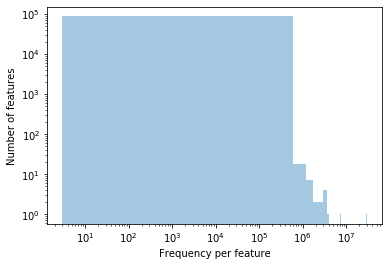

In [147]:
# Visualize the filtered table
feature_filter_vis = feature_table.visualizers.summarize(table=feature_filter.filtered_table,
                                                         sample_metadata=meta_data)

In [149]:
#feature_filter_vis.visualization